# Stock Price Movement Prediction (Classification)

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

# Import libraries with warning suppression
import warnings
warnings.filterwarnings('ignore')  # Hide all warnings

# Load the stock features CSV
df = pd.read_csv("/workspaces/codespaces-jupyter/Assignment/data/stock_features.csv")
df.head()


,Date,Open,High,Low,Close,Volume,return_pct,volume_change,ma_5,ma_20,std_5,std_20,price_diff,target_up_down
0,2005-02-01,364.5974,372.7410,361.2580,369.7766,41525725.0,0.018680,1.009028,355.13828,355.76177,11.845389,8.658899,5.1792,0
1,2005-02-02,372.7754,373.1158,357.1008,363.8136,16445522.0,-0.016126,-0.603968,359.56116,355.44658,9.461712,8.212042,-8.9618,1
2,2005-02-03,364.5974,370.3900,364.5974,368.7542,8457708.0,0.013580,-0.485714,364.31792,355.79755,5.398699,8.634089,4.1568,0
3,2005-02-04,369.3676,371.6846,362.9278,365.5174,14332299.0,-0.008778,0.694584,366.17156,356.01735,2.989081,8.830474,-3.8502,0
4,2005-02-07,366.3012,367.9366,355.0564,361.2918,9380478.0,-0.011561,-0.345501,365.83072,356.16045,3.495906,8.894583,-5.0094,1


# Feature Selection and Target Preparation

In [3]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'return_pct',
       'volume_change', 'ma_5', 'ma_20', 'std_5', 'std_20', 'price_diff',
       'target_up_down'],
      dtype='object')

In [4]:
# Feature Selection
# Selecting features
selected_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'return_pct',
       'volume_change', 'ma_5', 'ma_20', 'std_5', 'std_20', 'price_diff']

In [5]:
X = df[selected_features]
y = df["target_up_down"]


In [6]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif


# Perform PCA for dimensionality reduction
n_components = min(X.shape[0], X.shape[1])
# Number of components should be less than or equal to the minimum of samples or features
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Perform feature selection on the PCA-transformed data
k_best_selector = SelectKBest(score_func=f_classif, k=5)
# Adjust k as needed
X_k_best = k_best_selector.fit_transform(X_pca, y)

# Get the indices of selected features
selected_indices = k_best_selector.get_support(indices=True)

# Map selected PCA components back to original feature names
selected_features = [selected_features[i] for i in selected_indices]

print("Selected features using ANOVA F-test after PCA:")
print(selected_features)

Selected features using ANOVA F-test after PCA:
['Open', 'return_pct', 'volume_change', 'ma_20', 'std_20']


In [7]:
X=X[selected_features]
X.head()

,Open,return_pct,volume_change,ma_20,std_20
0,364.5974,0.018680,1.009028,355.76177,8.658899
1,372.7754,-0.016126,-0.603968,355.44658,8.212042
2,364.5974,0.013580,-0.485714,355.79755,8.634089
3,369.3676,-0.008778,0.694584,356.01735,8.830474
4,366.3012,-0.011561,-0.345501,356.16045,8.894583


# Train/Test Split and Model Training

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.decomposition import PCA

# Split without shuffling to respect time order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Random Forest Classifier

In [9]:
# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Score:", np.mean(cv_scores))

Cross-validation Scores: [0.47738693 0.44974874 0.52512563 0.50753769 0.51884422]
Mean Cross-validation Score: 0.4957286432160804


In [11]:
# Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Random Forest Classifier Model Evaluation:")
print("Accuracy:", accuracy)

Random Forest Classifier Model Evaluation:
Accuracy: 0.5170682730923695


In [12]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [1, 5, 10],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 10}


In [13]:
# Model Evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.4939759036144578
Confusion Matrix:
 [[295 184]
 [320 197]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.62      0.54       479
           1       0.52      0.38      0.44       517

    accuracy                           0.49       996
   macro avg       0.50      0.50      0.49       996
weighted avg       0.50      0.49      0.49       996



# XG Boost model

In [24]:
# Train with XGBoost Model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

XGmodel = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss'
)

XGmodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
# Cross-validation
cv_scores = cross_val_score(XGmodel, X_train, y_train, cv=5)
print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Score:", np.mean(cv_scores))

Cross-validation Scores: [0.4861809  0.45603015 0.54396985 0.50628141 0.50879397]
Mean Cross-validation Score: 0.500251256281407


In [26]:
# Model Evaluation
y_pred = XGmodel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("XG Boost Model Evaluation:")
print("Accuracy:", accuracy)

XG Boost Model Evaluation:
Accuracy: 0.5200803212851406


In [31]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
tuned_params = grid_search.best_params_
tuned_model = grid_search.best_estimator_
print("Best Hyperparameters:", tuned_params)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:28:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_split", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:28:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_split", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:28:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_split", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:28:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_features"

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


In [32]:
# Model Evaluation
y_pred = tuned_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.5
Confusion Matrix:
 [[271 208]
 [290 227]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.57      0.52       479
           1       0.52      0.44      0.48       517

    accuracy                           0.50       996
   macro avg       0.50      0.50      0.50       996
weighted avg       0.50      0.50      0.50       996



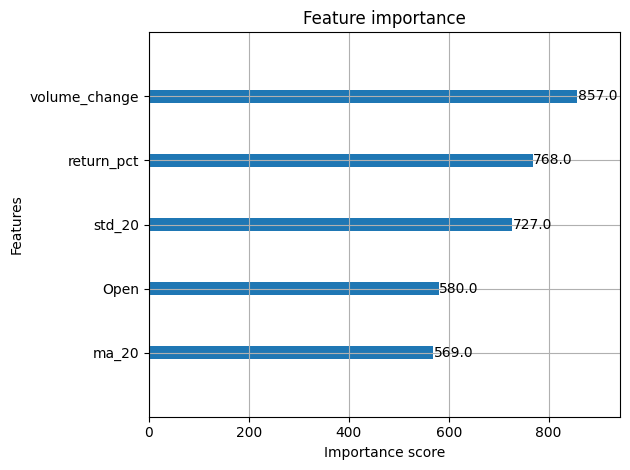

In [33]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(tuned_model, max_num_features=10)
plt.tight_layout()
plt.show()

# Save Trained Model

In [34]:
import joblib
import os

# Saving the model
joblib.dump(tuned_model, '/workspaces/codespaces-jupyter/Assignment/Model/model.pkl')

['/workspaces/codespaces-jupyter/Assignment/Model/model.pkl']